**101: Tüm Ürünler, Multi-Output Tek Katmanlı MLP Modelleme**  
TRAIN

Amaç: Tüm ürünler için miktar tahmini yapmak.

Girdi:  
- X_train_multi.npy → Tüm ürünler için fiyat, lag, rolling mean, datetime öznitelikleri  
- y_train_multi.npy → Tüm ürünlerin miktar değerleri

Çıktı: Tüm ürünler için çok çıkışlı miktar tahmini.

Model: Tek gizli katmanlı Multi-Layer Perceptron (MLP)

Aktivasyon: ReLU

Kayıp Fonksiyonu: Mean Squared Error (MSE)

Optimizasyon: El yazması geri yayılım (backpropagation) + Grid Search + Mini Batch + Early Stopping

Çıktılar:  
- Her parametre kombinasyonu için öğrenme eğrileri (Learning Curve) çizilir.  
- En iyi ağırlıklar: `models/101_W1.npy`, `101_b1.npy`, `101_W2.npy`, `101_b2.npy` dosyalarına kaydedilir.


1- Kütüphaneler ve Veri Yükleme

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os

X1_train = np.load('npy/X_train_multi.npy')
y_train = np.load('npy/y_train_multi.npy')
X1_test = np.load('npy/X_test_multi.npy')
y_test = np.load('npy/y_test_multi.npy')

print(f"X1_train: {X1_train.shape} | y_train: {y_train.shape}")


X1_train: (210239, 52) | y_train: (210239, 16)


2- Parametreler ve Model Ayarları

In [32]:
num_outputs = y_train.shape[1]
input_dim = X1_train.shape[1]

hidden_dim_list = [128]
lr_list = [0.001]
batch_size_list = [8]

epochs = 50
patience = 7

best_mse_global = float('inf')
best_config = None

if not os.path.exists('models'):
    os.makedirs('models')

def relu(x): return np.maximum(0, x)
def relu_derivative(x): return (x > 0).astype(float)


3- Grid Search Döngüsü


Deneme: hidden_dim=128, lr=0.001, batch_size=8
Epoch 1/50 | Train MSE: 0.2056 | Test MSE: 0.2064
Epoch 2/50 | Train MSE: 0.2037 | Test MSE: 0.2077
Epoch 3/50 | Train MSE: 0.2017 | Test MSE: 0.2014
Epoch 4/50 | Train MSE: 0.2013 | Test MSE: 0.2008
Epoch 5/50 | Train MSE: 0.2011 | Test MSE: 0.2007
Epoch 6/50 | Train MSE: 0.2013 | Test MSE: 0.2003
Epoch 7/50 | Train MSE: 0.2010 | Test MSE: 0.2017
Epoch 8/50 | Train MSE: 0.2017 | Test MSE: 0.2000
Epoch 9/50 | Train MSE: 0.2001 | Test MSE: 0.1975
Epoch 10/50 | Train MSE: 0.2001 | Test MSE: 0.2010
Epoch 11/50 | Train MSE: 0.2001 | Test MSE: 0.2010
Epoch 12/50 | Train MSE: 0.2001 | Test MSE: 0.2069
Epoch 13/50 | Train MSE: 0.2004 | Test MSE: 0.2026
Epoch 14/50 | Train MSE: 0.1997 | Test MSE: 0.2013
Epoch 15/50 | Train MSE: 0.1993 | Test MSE: 0.2002
Epoch 16/50 | Train MSE: 0.1996 | Test MSE: 0.2067
Early stopping at epoch 16
Kombinasyon En iyi Test MSE: 0.1975


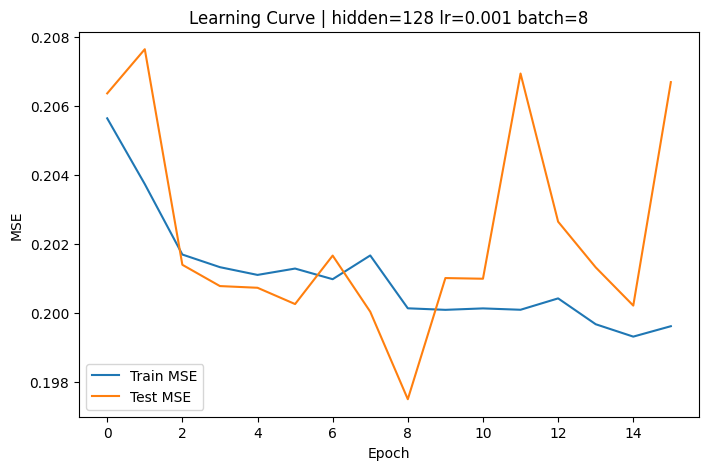

In [33]:
for hidden_dim in hidden_dim_list:
    for lr in lr_list:
        for batch_size in batch_size_list:

            print(f"\nDeneme: hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}")


            np.random.seed(42)
            W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2. / input_dim)
            b1 = np.zeros((1, hidden_dim))
            W2 = np.random.randn(hidden_dim, num_outputs) * np.sqrt(2. / hidden_dim)
            b2 = np.zeros((1, num_outputs))

            best_test_mse = float('inf')
            patience_counter = 0

            train_mse_list, test_mse_list = [], []

            for epoch in range(epochs):
                permutation = np.random.permutation(X1_train.shape[0])
                X_shuffled = X1_train[permutation]
                y_shuffled = y_train[permutation]

                for i in range(0, X1_train.shape[0], batch_size):
                    X_b = X_shuffled[i:i+batch_size]
                    y_b = y_shuffled[i:i+batch_size]

                    Z1 = X_b.dot(W1) + b1
                    A1 = relu(Z1)
                    Z2 = A1.dot(W2) + b2
                    y_pred = Z2

                    dZ2 = 2 * (y_pred - y_b) / y_b.shape[0]
                    dW2 = A1.T.dot(dZ2)
                    db2 = np.sum(dZ2, axis=0, keepdims=True)

                    dA1 = dZ2.dot(W2.T)
                    dZ1 = dA1 * relu_derivative(Z1)
                    dW1 = X_b.T.dot(dZ1)
                    db1 = np.sum(dZ1, axis=0, keepdims=True)

                    W2 -= lr * dW2
                    b2 -= lr * db2
                    W1 -= lr * dW1
                    b1 -= lr * db1

                Z1_train = X1_train.dot(W1) + b1
                A1_train = relu(Z1_train)
                Z2_train = A1_train.dot(W2) + b2
                y_train_pred = Z2_train
                train_mse = np.mean((y_train - y_train_pred)**2)

                Z1_test = X1_test.dot(W1) + b1
                A1_test = relu(Z1_test)
                Z2_test = A1_test.dot(W2) + b2
                y_test_pred = Z2_test
                test_mse = np.mean((y_test - y_test_pred)**2)

                train_mse_list.append(train_mse)
                test_mse_list.append(test_mse)

                print(f"Epoch {epoch+1}/{epochs} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}")

                if test_mse < best_test_mse:
                    best_test_mse = test_mse
                    patience_counter = 0
                    best_W1, best_b1, best_W2, best_b2 = W1.copy(), b1.copy(), W2.copy(), b2.copy()
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

            print(f"Kombinasyon En iyi Test MSE: {best_test_mse:.4f}")

            if best_test_mse < best_mse_global:
                best_mse_global = best_test_mse
                best_config = (hidden_dim, lr, batch_size)
                final_W1, final_b1, final_W2, final_b2 = best_W1, best_b1, best_W2, best_b2

            plt.figure(figsize=(8,5))
            plt.plot(train_mse_list, label='Train MSE')
            plt.plot(test_mse_list, label='Test MSE')
            plt.title(f'Learning Curve | hidden={hidden_dim} lr={lr} batch={batch_size}')
            plt.xlabel('Epoch')
            plt.ylabel('MSE')
            plt.legend()
            plt.show()


4- Grid Search Sonuçları ve En İyi Model Kayıt

In [34]:
print("\n=== EN İYİ KONFİGÜRASYON ===")
print(f"hidden_dim={best_config[0]}, lr={best_config[1]}, batch_size={best_config[2]}")
print(f"En düşük Test MSE: {best_mse_global:.4f}")

# Kaydet
np.save('models/101_W1.npy', final_W1)
np.save('models/101_b1.npy', final_b1)
np.save('models/101_W2.npy', final_W2)
np.save('models/101_b2.npy', final_b2)

print("En iyi grid search modeli 'models/' klasörüne kaydedildi.")



=== EN İYİ KONFİGÜRASYON ===
hidden_dim=128, lr=0.001, batch_size=8
En düşük Test MSE: 0.1975
En iyi grid search modeli 'models/' klasörüne kaydedildi.
